# Node embeddings

## Data loading

In [1]:
# Import libraries

import numpy as np
import os
#import utils_preproc
import pandas as pd

In [2]:
# Load data

basepath = './'
basepath_data = os.path.join(basepath, 'data/')

scan_types = ["FA", "GM", "RS"]

all_nodes = {i+1 for i in range(76)}

In [3]:
processed_method = ["original", "salience_kr", "salience_krfals", "threshold", "sparsification"]
all_filepaths = []

for i in range(3):
    current_scan_type = scan_types[i]
    # List all files in the directory and filter those starting with current scan type
    #file_paths = [f for f in os.listdir(basepath_data) if f.startswith(current_scan_type) and f.endswith('.npy')]
    # Create the list manually bc I want spars to be at the end and original at the beginning
    file_names = [current_scan_type + "_" + method + ".npy" for method in processed_method]

    # Full file paths (assuming the files are in the current directory)
    file_paths = [os.path.join(basepath_data, f) for f in file_names]

    print(file_paths)

    all_filepaths.append(file_paths)

['./data/FA_original.npy', './data/FA_salience_kr.npy', './data/FA_salience_krfals.npy', './data/FA_threshold.npy', './data/FA_sparsification.npy']
['./data/GM_original.npy', './data/GM_salience_kr.npy', './data/GM_salience_krfals.npy', './data/GM_threshold.npy', './data/GM_sparsification.npy']
['./data/RS_original.npy', './data/RS_salience_kr.npy', './data/RS_salience_krfals.npy', './data/RS_threshold.npy', './data/RS_sparsification.npy']


In [4]:
# Load and stack all arrays for each scan type, along the last axis (axis=-1)
# This will give us shape (270, 76, 76, 5) for each scan type (original + 4 thresholded versions)
data = np.stack([np.stack([np.load(file) for file in files], axis=-1) for files in all_filepaths], axis=-2)

print(data.shape)  # Output: (270, 76, 76, 3, 5)

(270, 76, 76, 3, 5)


Per tant: data[:,:,:,0,0] és FA original; data[:,:,:,0,1] és salienced; data[:,:,:,1,0] és GM original; etc.


## First attempt

In [5]:
original_data = np.load("./data/data.npy")
print(f'Data succesfully loaded: {original_data.shape}')

# Extract the original data part (i.e., data[:,:,:,:,0])
# This gives a shape of (270, 76, 76, 3)
original_data = data[:,:,:,:,0]

# Check if all the matrices across the scan types (FA, GM, RS) are the same
# We compare the first matrix (FA_original) with the others (GM_original and RS_original)

# Compare the first matrices element-wise
are_same = np.all(original_data[:,:,:,0] == data[:,:,:,0,0])  # Check FA and original
are_same &= np.all(original_data[:,:,:,1] == data[:,:,:,1,0])  # Check GM and original
are_same &= np.all(original_data[:,:,:,2] == data[:,:,:,2,0])  # Check RS and original

# Print the result
if are_same:
    print("The matrices are the same as originals across the three scan types (FA, GM, RS).")
else:
    print("The matrices are not the same as originals across the three scan types (FA, GM, RS).")


# Compare the first matrices element-wise
are_same = np.all(original_data[:,:,:,0] == data[:,:,:,0,3])  # Check FA original and thresholded
are_same &= np.all(original_data[:,:,:,1] == data[:,:,:,1,3])  # Check GM original and thresholded
are_same &= np.all(original_data[:,:,:,2] == data[:,:,:,2,3])  # Check RS original and thresholded

# Print the result
if are_same:
    print("The matrices are the same as originals across the three scan types (FA, GM, RS).")
else:
    print("The matrices are not the same as originals across the three scan types (FA, GM, RS).")


Data succesfully loaded: (270, 76, 76, 3)
The matrices are the same as originals across the three scan types (FA, GM, RS).
The matrices are not the same as originals across the three scan types (FA, GM, RS).


NODE METRICS GIVEN BY CHATGPT

In [35]:
import networkx as nx
import numpy as np
from networkx.algorithms import community
from networkx.algorithms.centrality import eigenvector_centrality, degree_centrality, betweenness_centrality
from networkx import clustering
from networkx.algorithms.community import modularity
from networkx import convert_matrix
from networkx.algorithms.shortest_paths import average_shortest_path_length
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [24]:
def calculate_rich_club_coefficient(G, top_percent=0.1):
    """
    Calculate the Rich Club Coefficient for the top x% highest degree nodes.
    
    Parameters:
    - G: The graph object (networkx.Graph).
    - top_percent: Percentage of the top degree nodes to consider for rich club.
    
    Returns:
    - rich_club: Rich club coefficient (ratio of actual/expected edges for the rich club).
    """
    degrees = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    num_nodes = len(G)
    top_n = int(num_nodes * top_percent)
    top_nodes = [node for node, _ in degrees[:top_n]]
    
    subgraph = G.subgraph(top_nodes)
    actual_edges = subgraph.number_of_edges()
    
    # Calculate expected edges (based on random graph model)
    expected_edges = top_n * (top_n - 1) / 2  # For a fully connected subgraph
    
    # Rich club coefficient is the ratio of actual edges to expected edges
    rich_club = actual_edges / expected_edges if expected_edges > 0 else 0
    return rich_club


In [ ]:
def more_extended_node_metrics(G):
    """
    Calculate various global brain network metrics for a given connectivity matrix.
    
    Parameters:
    - G: A networkx graph representing the connectivity matrix
                of the brain network (e.g., FA, GM, or RS data).
    
    Returns:
    - metrics: A dictionary containing the calculated metrics.
    """
    # Convert the connectivity matrix to a graph (using thresholded adjacency matrix)
    #G = nx.from_numpy_matrix(connectivity_matrix)

    # Degree Centrality
    degree_central = degree_centrality(G)
    
    # Betweenness Centrality
    betweenness_central = betweenness_centrality(G)
    
    # Clustering Coefficient
    clustering_coeff = clustering(G)
    
    # Global Efficiency
    # Global efficiency is the inverse of the average shortest path length
    try:
        avg_path_length = average_shortest_path_length(G)
        global_eff = 1 / avg_path_length if avg_path_length != 0 else 0
    except nx.NetworkXError:  # in case the graph is not connected
        global_eff = 0
    
    # Eigenvector Centrality
    eig_central = eigenvector_centrality(G)
    
    # Modularity (Using the Louvain method)
    partitions = community.louvain_communities(G, weight=None)
    modularity_score = modularity(G, partitions)
    
    # Small-Worldness: Comparing clustering coefficient and path length to random graphs
    avg_clustering = np.mean(list(clustering_coeff.values()))
    try:
        avg_path_length = average_shortest_path_length(G)
    except nx.NetworkXError:  # in case the graph is not connected
        avg_path_length = float('inf')
    
    # Rich Club Coefficient (Top x% highest degree nodes)
    rich_club = calculate_rich_club_coefficient(G)
    
    # Collecting all metrics into a dictionary
    metrics = {
        "Degree Centrality": degree_central,
        "Betweenness Centrality": betweenness_central,
        "Clustering Coefficient": clustering_coeff,
        "Global Efficiency": global_eff,
        "Eigenvector Centrality": eig_central,
        "Modularity": modularity_score,
        "Small-Worldness": (avg_clustering, avg_path_length),
        "Rich Club Coefficient": rich_club
    }
    
    return metrics


In [139]:
# Custom weighted degree centrality
def weighted_degree_centrality(G):
    centrality = {}
    for node in G.nodes():
        # Sum the weights of the edges connected to the node
        centrality[node] = sum(d['weight'] for _, d in G[node].items())
    
    # Normalize by the maximum possible weighted degree
    max_weighted_degree = max(centrality.values())
    for node in centrality:
        centrality[node] /= max_weighted_degree  # Normalize to [0, 1]
    
    return centrality

In [ ]:
def extended_node_metrics(G):
    """
    Calculate various global brain network metrics for a given connectivity matrix.
    
    Parameters:
    - G: A networkx graph representing the connectivity matrix
                of the brain network (e.g., FA, GM, or RS data).
    
    Returns:
    - metrics: A dictionary containing the calculated metrics.
    """
    # Convert the connectivity matrix to a graph (using thresholded adjacency matrix)
    #G = nx.from_numpy_matrix(connectivity_matrix)

    # Degree Centrality
    degree_central = degree_centrality(G)
    
    # Weighted Degree Centrality
    weighted_degree_central = weighted_degree_centrality(G)

    # Betweenness Centrality
    betweenness_central = betweenness_centrality(G, weight='weight')
    
    # Clustering Coefficient
    clustering_coeff = clustering(G, weight='weight')
    
    # Global Efficiency: is the inverse of the average shortest path length
    try:
        avg_path_length = average_shortest_path_length(G)
        global_eff = 1 / avg_path_length if avg_path_length != 0 else 0
    except nx.NetworkXError:  # in case the graph is not connected
        global_eff = 0
    
    # Collecting all metrics into a dictionary
    metrics = {
        "Degree_Centrality": degree_central,
        "Weighted_Degree_Centrality": weighted_degree_central,
        "Betweenness_Centrality": betweenness_central,
        "Clustering_Coefficient": clustering_coeff,
        "Global_Efficiency": global_eff
    }
    
    return metrics

(Codes to check if betweenness changes weighted vs unweighted; it seems like doesn't change)

En canvi per la degree centrality sí que canvia...

In [136]:
import networkx as nx

for _ in range(100):  # Loop 100 times (as in your original code)
    G = nx.from_numpy_array(data[i, :, :, 0, 0])  # Create graph from your numpy array data
    
    # Calculate betweenness centrality for the graph without weights
    betweenness_unweighted = nx.betweenness_centrality(G)
    
    # Calculate betweenness centrality with edge weights
    betweenness_weighted = nx.betweenness_centrality(G, weight='weights')
    
    # Calculate the difference in betweenness centrality for each node
    for node in betweenness_unweighted:
        diff = betweenness_unweighted[node] - betweenness_weighted[node]
        
        if diff > 0:
            print(f"Difference is positive for node {node}: {diff}")


In [140]:
import networkx as nx

for _ in range(100):  # Loop 100 times (as in your original code)
    G = nx.from_numpy_array(data[i, :, :, 0, 0])  # Create graph from your numpy array data
    
    # Calculate betweenness centrality for the graph without weights
    betweenness_unweighted = nx.degree_centrality(G)
    
    # Calculate betweenness centrality with edge weights
    betweenness_weighted = weighted_degree_centrality(G)
    
    # Calculate the difference in betweenness centrality for each node
    for node in betweenness_unweighted:
        diff = betweenness_unweighted[node] - betweenness_weighted[node]
        
        if diff > 0:
            print(f"Difference is positive for node {node}: {diff}")


Difference is positive for node 2: 0.00986997104483367
Difference is positive for node 3: 0.07324841696610956
Difference is positive for node 4: 0.03644414845285093
Difference is positive for node 6: 0.0056430763808587026
Difference is positive for node 9: 0.04597236382417169
Difference is positive for node 10: 0.050712186177269136
Difference is positive for node 11: 0.05060552290824172
Difference is positive for node 12: 0.00935940081199349
Difference is positive for node 13: 0.01095861669012188
Difference is positive for node 16: 0.022235138403774668
Difference is positive for node 17: 0.007698069051049639
Difference is positive for node 18: 0.007005358826457753
Difference is positive for node 23: 0.03173782280045356
Difference is positive for node 24: 0.006666295272917067
Difference is positive for node 27: 0.006272158238391667
Difference is positive for node 30: 0.0038002944861097454
Difference is positive for node 32: 0.050137575518980126
Difference is positive for node 33: 0.0184

In [99]:
data.shape

(270, 76, 76, 3, 5)

In [ ]:
# Example usage:
# Assume you have a connectivity matrix (e.g., FA, GM, or RS data)

for method in [3,4]:
    print(f"--- Method: {method}")
    for patient in range(270):
        matrix = data[patient,:,:,2,method]
        G = utils_preproc.adjacency_matrix_to_graph(matrix)

        metrics = extended_node_metrics(G)
        print(f"patient {patient} okay.")
    #    # Print metrics
    #    for metric, value in metrics.items():
    #        print(f"{metric}: {value}")

--- Method: 3
patient 0 okay.
patient 1 okay.
patient 2 okay.
patient 3 okay.
patient 4 okay.
patient 5 okay.
patient 6 okay.
patient 7 okay.
patient 8 okay.
patient 9 okay.
patient 10 okay.
patient 11 okay.
patient 12 okay.
patient 13 okay.
patient 14 okay.
patient 15 okay.
patient 16 okay.
patient 17 okay.
patient 18 okay.
patient 19 okay.
patient 20 okay.
patient 21 okay.
patient 22 okay.
patient 23 okay.
patient 24 okay.
patient 25 okay.
patient 26 okay.
patient 27 okay.
patient 28 okay.
patient 29 okay.
patient 30 okay.
patient 31 okay.
patient 32 okay.
patient 33 okay.
patient 34 okay.
patient 35 okay.
patient 36 okay.
patient 37 okay.
patient 38 okay.
patient 39 okay.
patient 40 okay.
patient 41 okay.
patient 42 okay.
patient 43 okay.
patient 44 okay.
patient 45 okay.
patient 46 okay.
patient 47 okay.
patient 48 okay.
patient 49 okay.
patient 50 okay.
patient 51 okay.
patient 52 okay.
patient 53 okay.
patient 54 okay.
patient 55 okay.
patient 56 okay.
patient 57 okay.
patient 58

In [ ]:
def calculate_metrics_for_graphs(graphs):
    """
    Calculate global brain network metrics for a list of graphs.
    
    Parameters:
    - graphs: A list of 2D NumPy arrays (connectivity matrices) representing brain network data.
    
    Returns:
    - metrics_list: A list of dictionaries containing the metrics for each graph.
    """
    metrics_list = []
    for graph in graphs:
        metrics = extended_node_metrics(graph)
        metrics_list.append(metrics)
    
    return metrics_list


In [44]:
def store_metrics(metrics_list):
    """
    Store metrics in a DataFrame for easy access and analysis.
    
    Parameters:
    - metrics_list: A list of dictionaries containing the metrics for each graph.
    
    Returns:
    - df: A Pandas DataFrame where each row is a graph and each column is a metric.
    """
    # Flatten the metrics into a list of dictionaries for easy conversion into DataFrame
    all_metrics = []
    for metrics in metrics_list:
        # Flattening the dictionary (metrics) for each graph
        flat_metrics = {}
        for metric, value in metrics.items():
            if isinstance(value, dict):  # For degree centrality and other node-wise metrics
                for sub_metric, sub_value in value.items():
                    flat_metrics[f"{metric}_{sub_metric}"] = sub_value
            elif isinstance(value, tuple):  # For small-worldness (avg_clustering, avg_path_length)
                flat_metrics[f"{metric}_avg_clustering"] = value[0]
                flat_metrics[f"{metric}_avg_path_length"] = value[1]
            else:
                flat_metrics[metric] = value
        all_metrics.append(flat_metrics)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_metrics)
    return df


In [45]:
def normalize_metrics(df):
    """
    Normalize the metrics (z-score normalization).
    
    Parameters:
    - df: A Pandas DataFrame containing the metrics.
    
    Returns:
    - df_normalized: A normalized DataFrame.
    """
    # Ensure all values in the dataframe are numeric
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    
    # Apply standard scaling (z-score normalization)
    scaler = StandardScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
    return df_normalized


In [38]:
# Example usage:

# Assume you have a list of connectivity matrices (graphs)
graphs = [utils_preproc.adjacency_matrix_to_graph(matrix) for matrix in data[:,:,:,0,0]]#[np.random.rand(10, 10) for _ in range(5)]  # Replace with actual graphs


In [46]:
# Step 1: Calculate the metrics for each graph
metrics_list = calculate_metrics_for_graphs(graphs)


In [47]:
# Step 2: Store the metrics in a DataFrame
df = store_metrics(metrics_list)


In [48]:
# Step 3: Normalize the metrics
df_normalized = normalize_metrics(df)



In [68]:
# Print normalized metrics
print(df)#_normalized)


     Degree Centrality_0  Degree Centrality_1  Degree Centrality_2  \
0               0.546667             0.653333             0.600000   
1               0.573333             0.706667             0.680000   
2               0.586667             0.613333             0.613333   
3               0.640000             0.693333             0.573333   
4               0.560000             0.666667             0.586667   
..                   ...                  ...                  ...   
265             0.626667             0.680000             0.746667   
266             0.680000             0.680000             0.693333   
267             0.573333             0.773333             0.693333   
268             0.506667             0.720000             0.706667   
269             0.600000             0.786667             0.760000   

     Degree Centrality_3  Degree Centrality_4  Degree Centrality_5  \
0               0.266667             0.600000             0.853333   
1               0.3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_normalized_metrics(df_normalized):
    """
    Plot each normalized metric from the DataFrame.
    
    Parameters:
    - df_normalized: A Pandas DataFrame containing the normalized metrics.
    
    Displays:
    - Individual plots for each normalized metric.
    """
    # Set up the seaborn style for better aesthetics
    sns.set(style="whitegrid")
    
    # Loop through each column (metric) in the normalized DataFrame
    for column in df_normalized.columns:
        plt.figure(figsize=(8, 6))  # Create a new figure for each plot
        sns.histplot(df_normalized[column], kde=True, color='skyblue', bins=15)
        
        # Add labels and title
        plt.title(f"Distribution of Normalized {column}", fontsize=14)
        plt.xlabel(f"{column}", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        
        # Show the plot
        plt.show()


# Example usage (after you have your normalized DataFrame df_normalized):
plot_normalized_metrics(df_normalized)


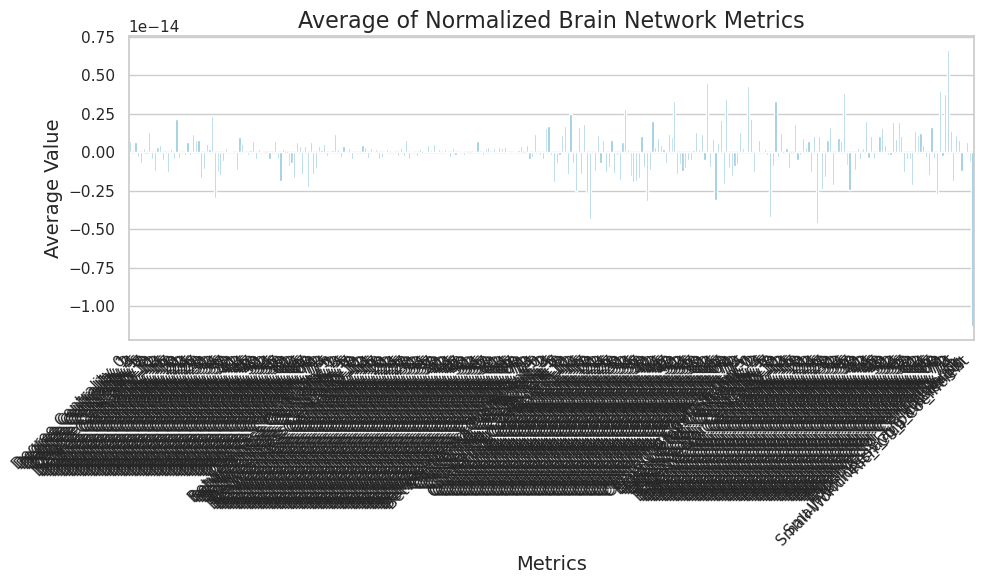

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_averaged_normalized_metrics(df_normalized):
    """
    Plot the average of each normalized metric across all samples.
    
    Parameters:
    - df_normalized: A Pandas DataFrame containing the normalized metrics.
    
    Displays:
    - A bar plot showing the average of each normalized metric.
    """
    # Calculate the mean of each metric across all samples (rows)
    avg_metrics = df_normalized.mean(axis=0)
    
    # Set up the seaborn style for better aesthetics
    sns.set(style="whitegrid")
    
    # Create a bar plot of the average metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_metrics.index, y=avg_metrics.values, color='skyblue')
    
    # Add labels and title
    plt.title("Average of Normalized Brain Network Metrics", fontsize=16)
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Average Value", fontsize=14)
    
    # Rotate x-axis labels for better readability (if needed)
    plt.xticks(rotation=45, ha='right')
    
    # Show the plot
    plt.tight_layout()  # To make sure everything fits nicely
    plt.show()


# Example usage (after you have your normalized DataFrame df_normalized):
plot_averaged_normalized_metrics(df_normalized)


In [ ]:
def save_metrics_as_csv(data, output_dir, subject_idx):
    """
    Save the metrics of a subject in a separate CSV file.
    
    Parameters:
    - data: A numpy array of shape (76, 76, 3, 5), where each subject has 76 nodes
      and each node has 60 values (3 scan types * 5 threshold versions * 4 metrics).
    - output_dir: The directory where the CSV files will be saved.
    - subject_idx: The index of the subject to process (from 0 to 269).
    """
    # Prepare an empty list to store all rows (one row per node)
    all_rows = []
    
    # Prepare the structure to store the metrics for each (scan_type_idx, threshold_version_idx)
    metrics_by_scan_and_threshold = {}

    # Calculate the metrics once for each combination of scan_type_idx and threshold_version_idx
    for scan_type_idx in range(data.shape[2]):  # 3 scan types (FA, GM, RS)
        for threshold_version_idx in range(data.shape[3]):  # 5 threshold versions
            # Extract the connectivity matrix for the current subject, all nodes, scan type, and threshold version
            connectivity_matrices = data[subject_idx, :, :, scan_type_idx, threshold_version_idx]  # Shape: (76, 76)
            
            # Convert the matrix to a NetworkX graph and compute the metrics
            G = nx.from_numpy_array(connectivity_matrices)
            
            # Compute the metrics for this graph
            subject_metrics = extended_node_metrics(G)
            
            # Store the calculated metrics for each node
            for node_idx in range(connectivity_matrices.shape[0]):
                if node_idx not in metrics_by_scan_and_threshold:
                    metrics_by_scan_and_threshold[node_idx] = {metric: [] for metric in subject_metrics}
                for metric, value in subject_metrics.items():
                    metrics_by_scan_and_threshold[node_idx][metric].append(value[node_idx])
    
    # Now create the rows for the CSV file (one row for each node)
    for node_idx in range(76):  # There are 76 nodes
        node_metrics = [node_idx]  # Start with the node index as the first column
        
        # Collect metrics for this node across all scan types and threshold versions
        for scan_type_idx in range(data.shape[2]):
            for threshold_version_idx in range(data.shape[3]):
                metrics = metrics_by_scan_and_threshold[node_idx]
                for metric in metrics:
                    node_metrics.append(np.mean(metrics[metric]))  # Use the mean value for each metric

        # Add the current node's metrics (including the node index) to the list of rows
        all_rows.append(node_metrics)
    
    # Convert the rows to a DataFrame
    column_names = ["Node"] + [f"Metric_{i+1}" for i in range(len(node_metrics) - 1)]  # Define the column names
    
    df = pd.DataFrame(all_rows, columns=column_names)
    
    # Save the DataFrame to the CSV file
    subject_filename = f"subject_{subject_idx + 1}_metrics.csv"
    df.to_csv(os.path.join(output_dir, subject_filename), index=False)

In [110]:
data[0,:,:,:,:].shape

(76, 76, 3, 5)

In [ ]:
def save_node_metrics_to_csv(data, output_file):
    """
    Save node metrics for all nodes for one subject, across all scan types and threshold versions
    in a CSV file where each row represents a node, and each column represents a metric.
    
    Parameters:
    - data: A numpy array of shape (76, 76, 3, 5), where each subject has 76 nodes
      and each node has 15 values (3 scan types * 5 threshold versions).
    - output_file: The path to the output CSV file where the metrics will be saved.
    """
    # Prepare an empty list to store all rows (one row per node)
    all_rows = []
    
    # Prepare the structure to store the metrics for each (scan_type_idx, threshold_version_idx)
    metrics_by_scan_and_threshold = {}

    # Calculate the metrics once for each combination of scan_type_idx and threshold_version_idx
    for scan_type_idx in range(data.shape[3]):
        for threshold_version_idx in range(data.shape[4]):
            # Extract the connectivity matrix for all subjects, nodes, scan type, and threshold version
            connectivity_matrices = data[:, :, :, scan_type_idx, threshold_version_idx]  # Shape: (270, 76, 76)
            
            # Convert each matrix to a NetworkX graph and compute the metrics
            metrics = {}
            for subject_idx in range(connectivity_matrices.shape[0]):
                matrix = connectivity_matrices[subject_idx]
                G = nx.from_numpy_array(matrix)
                
                # Compute the metrics for this graph
                subject_metrics = extended_node_metrics(G)
                
                # Store the metrics for each node (flattening the dictionary for all nodes)
                for node_idx in range(matrix.shape[0]):
                    if node_idx not in metrics:
                        metrics[node_idx] = {metric: [] for metric in subject_metrics}
                    for metric, value in subject_metrics.items():
                        metrics[node_idx][metric].append(value[node_idx])
            
            # Store the calculated metrics in the dictionary
            metrics_by_scan_and_threshold[(scan_type_idx, threshold_version_idx)] = metrics
    
    # Now create the rows for the CSV file (one row for each node)
    for node_idx in range(76):  # There are 76 nodes
        node_metrics = [node_idx]  # Start with the node index as the first column
        
        # Collect metrics for this node across all scan types and threshold versions
        for scan_type_idx in range(data.shape[3]):
            for threshold_version_idx in range(data.shape[4]):
                metrics = metrics_by_scan_and_threshold[(scan_type_idx, threshold_version_idx)]
                for metric in metrics[node_idx]:
                    node_metrics.append(np.mean(metrics[node_idx][metric]))  # Use the mean value for each metric
                
        # Add the current node's metrics (including the node index) to the list of rows
        all_rows.append(node_metrics)
    
    # Convert the rows to a DataFrame
    column_names = ["Node"] + [f"Metric_{i+1}" for i in range(len(node_metrics) - 1)]  # Define the column names
    
    df = pd.DataFrame(all_rows, columns=column_names)
    
    # Save the DataFrame to the CSV file
    df.to_csv(output_file, index=False)


In [ ]:

# Example usage
# Assuming `combined_data` is the array with shape (270, 76, 76, 3, 5)
# and the output file path is './node_metrics.csv'
save_node_metrics_to_csv(data, './node_metrics.csv')

In [109]:

# Example usage
# Assuming `combined_data` is the array with shape (270, 76, 76, 3, 5)
# and the output directory for CSV files is './subject_metrics_csv'
save_metrics_as_csv(data, './subject_metrics_csv')


Succesfully saved as: subject_0000_metrics.csv


KeyboardInterrupt: 

# New approach

## Data loading (again)

In [1]:
# Import libraries

import numpy as np
import os
import utils_preproc
import pandas as pd
import networkx as nx
import csv

In [2]:
# Load data

basepath = './'
basepath_data = os.path.join(basepath, 'data/')

scan_types = ["FA", "GM", "RS"]

all_nodes = {i+1 for i in range(76)}

In [3]:
processed_method = ["original", "salience_kr", "salience_krfals", "threshold"]#, "sparsification"] DESCARTAT
all_filepaths = []

for i in range(3):
    current_scan_type = scan_types[i]
    # List all files in the directory and filter those starting with current scan type
    #file_paths = [f for f in os.listdir(basepath_data) if f.startswith(current_scan_type) and f.endswith('.npy')]
    # Create the list manually bc I want spars to be at the end and original at the beginning
    file_names = [current_scan_type + "_" + method + ".npy" for method in processed_method]

    # Full file paths (assuming the files are in the current directory)
    file_paths = [os.path.join(basepath_data, f) for f in file_names]

    print(file_paths)

    all_filepaths.append(file_paths)

['./data/FA_original.npy', './data/FA_salience_kr.npy', './data/FA_salience_krfals.npy', './data/FA_threshold.npy']
['./data/GM_original.npy', './data/GM_salience_kr.npy', './data/GM_salience_krfals.npy', './data/GM_threshold.npy']
['./data/RS_original.npy', './data/RS_salience_kr.npy', './data/RS_salience_krfals.npy', './data/RS_threshold.npy']


In [50]:
# Load and stack all arrays for each scan type, along the last axis (axis=-1)
# This will give us shape (270, 76, 76, 5) for each scan type (original + 4 thresholded versions)
data = np.stack([np.stack([np.load(file) for file in files], axis=-1) for files in all_filepaths], axis=-2)

print(data.shape)  # Output: (270, 76, 76, 3, 5)

(270, 76, 76, 3, 4)


Per tant: data[:,:,:,0,0] és FA original; data[:,:,:,0,1] és salienced; data[:,:,:,1,0] és GM original; etc.


Functions

In [5]:
def merge_dicts(*dicts):
    # Get all unique keys across all dictionaries
    all_keys = set(key for d in dicts for key in d)
    
    # Create the merged dictionary with lists of values from each input dictionary
    merged_dict = {key: [d.get(key) for d in dicts] for key in all_keys}
    
    return merged_dict

In [6]:
def append_dicts(dict1, dict2):
    for key, value in dict2.items():
        if key in dict1:
            dict1[key].append(value)
        else:
            print("Error keys: dict2 key does not exist in dict1. Creating new key.")
            dict1[key] = [value]

    return(dict1)

Experiments

In [12]:
dummy_graph = data[0, :,:, 0, 0]
dummy_graph = nx.from_numpy_array(dummy_graph)

In [60]:
embedd1 = nx.degree_centrality(dummy_graph)
embedd2 = nx.betweenness_centrality(dummy_graph)
embedd = merge_dicts(embedd1, embedd2)
print(embedd)

{0: [0.5466666666666667, 0.0014945567778541036], 1: [0.6533333333333333, 0.0024329991552537915], 2: [0.6000000000000001, 0.003618379031579992], 3: [0.26666666666666666, 1.5667841754798278e-05], 4: [0.6000000000000001, 0.0032712388139345947], 5: [0.8533333333333334, 0.010562347660162822], 6: [0.68, 0.005583596794949672], 7: [0.7733333333333334, 0.007990565075936477], 8: [0.6533333333333333, 0.005501173381057146], 9: [0.5733333333333334, 0.0034998205839661314], 10: [0.56, 0.003538705539820756], 11: [0.52, 0.0030708477148649062], 12: [0.7066666666666667, 0.006262800154299356], 13: [0.37333333333333335, 0.0008394278438316492], 14: [0.52, 0.0005138566466321479], 15: [0.6666666666666667, 0.0035736917422991015], 16: [0.49333333333333335, 0.0013875321379437755], 17: [0.6133333333333334, 0.002661342182228166], 18: [0.5466666666666667, 0.002525009664649225], 19: [0.6666666666666667, 0.0029635348911309844], 20: [0.5733333333333334, 0.0009478305168633168], 21: [0.6666666666666667, 0.00320439859017

In [48]:
d1 = nx.clustering(dummy_graph)
d2 = nx.clustering(dummy_graph, weight='weight')
for i in range(len(d1)):
    if d1[i] == d2[i]:
        print("equal")

Metrics: degree centrality, betwenness centrality, weighted betw centr, clustering coeff, weighted clustering coeff

In [54]:
G = dummy_graph

In [61]:
m1 = nx.degree_centrality(G)
m2 = nx.betweenness_centrality(G)
m3 = nx.betweenness_centrality(G, weight='weight')
m4 = nx.clustering(G)
m5 = nx.clustering(G, weight='weight')

metrics = merge_dicts(m1, m2, m3, m4, m5)#{key: [m1[key], m2[key], m3[key], m4[key], m5[key]] for key in m1}

In [70]:
#metr1 = merge_dicts(m1, m2)
#metr2 = merge_dicts(metr1, m3)
#metr2

dict1 = merge_dicts(m1, m2)
dict2 = append_dicts(dict1, m3)
dict2 == merge_dicts(m1, m2, m3)

True

If we wanted to save the metrics used in another entry for remembering the orders. If not, don't.

In [80]:
'''
metric_names = ['degree_centrality', 'betweenness_centrality', 'weighted_betweenness_centrality', 'clustering_coeff', 'weighted_clustering_coeff']

def insert_at_beginning(d, key, value):
    # Create a new dictionary with the new item at the beginning
    new_dict = {key: value}
    # Add the rest of the items from the original dictionary
    new_dict.update(d)
    return new_dict

d = insert_at_beginning(metrics, 'metric', metric_names)
d
'''

"\nmetric_names = ['degree_centrality', 'betweenness_centrality', 'weighted_betweenness_centrality', 'clustering_coeff', 'weighted_clustering_coeff']\n\ndef insert_at_beginning(d, key, value):\n    # Create a new dictionary with the new item at the beginning\n    new_dict = {key: value}\n    # Add the rest of the items from the original dictionary\n    new_dict.update(d)\n    return new_dict\n\nd = insert_at_beginning(metrics, 'metric', metric_names)\nd\n"

Automatization for all scans.

In [10]:
def save_csv_file(metrics, output_dir, file_name):
    """
    Save node metrics to a CSV file.
    
    Parameters:
    - metrics: Dictionary where keys are node identifiers and values are lists of calculated metrics.
    - output_dir: Directory to save the CSV file.
    - file_name: Name of the output CSV file.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the full file path
    file_to_open = os.path.join(output_dir, file_name)
    
    # Write the data to the CSV file
    with open(file_to_open, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow([
            'Node',
            'Degree Centrality',
            'Betweenness Centrality',
            'Weighted Betweenness Centrality',
            'Clustering Coefficient',
            'Weighted Clustering Coefficient'
        ])
        
        # Write data rows
        for key, values in metrics.items():
            writer.writerow([key] + values)

In [ ]:
output_dir = './node_embeddings'

for subject_id in range(5):#range(data.shape[0]):
    for scan_type_id in range(data.shape[3]):
        for method_id in range(data.shape[4]):
            # Get the graph from the adjacency matrix
            G = utils_preproc.adjacency_matrix_to_graph(data[subject_id, :, :, scan_type_id, method_id])

            # Calculate the metrics for each graph
            m1 = nx.degree_centrality(G)
            m2 = nx.betweenness_centrality(G)
            m3 = nx.betweenness_centrality(G, weight='weight')
            m4 = nx.clustering(G)
            m5 = nx.clustering(G, weight='weight')

            # Aggregate them in the same dictionary
            metrics = merge_dicts(m1, m2, m3, m4, m5)

            # Save the data to a CSV file
            subject_filename = f"{subject_id:04}_{scan_types[scan_type_id]}_{processed_method[method_id]}_embed.csv"
            save_csv_file(metrics, output_dir, subject_filename)

In [13]:
# Ha tardat 7.2 segons a fer 3 subjectes. Si tenim 270 subjectes, tardarà: 648s = 10.8 minuts :___)))
# Ha tardat 12.5 segons a fer 5 subjs. Seran 675s = 11.25 minuts :__________________________________)

Cada subjecte té en total 15 csv's (3 scan types * 5 preprocessing results), en els quals hi ha 5 mètriques a dins.

Cada node de cada subjecte té, doncs, 15*5 = 75 valors associats per fer l'embedding.

Encara falten els valors dels random walks del Jan i els node volumes: 15*(5+3) = 96 valors per cada node.

Reduim: no fem servir sparsification (pq hauria de tenir en compte els pesos de les arestes) i agafem 3 mètriques (totes amb pesos): 3\*4*(3+1+1) = 12*5 = 60 valors :)

GPT: is there any way to optimize this?

Also: a l'hora de tenir en compte els pesos, els valors alts són importants -> invertim.

In [38]:
def betweenness_centrality_inv(G, weight='weight'):
    # invertim pq les mes grans es tornin les mes petites
    for u, v, w in G.edges(data=True):
        w[weight] = -w[weight]
    
    return nx.betweenness_centrality(G)

def clustering_inv(G, weight='weight'):
    # invertim pq les mes grans es tornin les mes petites
    for u, v, w in G.edges(data=True):
        w[weight] = -w[weight]
    
    return nx.clustering(G)

In [45]:
data.shape

(270, 76, 76, 3, 4)

In [ ]:
import os
import csv
import networkx as nx
from concurrent.futures import ProcessPoolExecutor
from functools import lru_cache

# Cache to avoid recomputation
@lru_cache(maxsize=None)
def calculate_metrics(G):
    """
    Calculates and returns all metrics for a given graph.
    This function is cached to prevent redundant calculations.
    """
    m1 = nx.degree_centrality(G)
    m2 = betweenness_centrality_inv(G, weight='weight')
    m3 = clustering_inv(G, weight='weight')
    m4 = 0#TODO: posar les mètriques que m'ha passat el Jan
    return merge_dicts(m1, m2, m3)

def save_csv_file(metrics, output_dir, file_name):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    file_to_open = os.path.join(output_dir, file_name)
    with open(file_to_open, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            'Node', 'Degree Centrality', 'Betweenness Centrality', 'Clustering Coefficient'
        ])
        for key, values in metrics.items():
            writer.writerow([key] + values)

def process_subject(subject_id, scan_type_id, method_id, output_dir):
    """
    Process a single subject's data and save the metrics to a CSV file.
    """
    G = utils_preproc.adjacency_matrix_to_graph(data[subject_id, :, :, scan_type_id, method_id])
    metrics = calculate_metrics(G)
    subject_filename = f"{subject_id:04}_{scan_types[scan_type_id]}_{processed_method[method_id]}_embed.csv"
    save_csv_file(metrics, output_dir, subject_filename)

# Main processing function with parallel execution
def process_all_subjects(data, output_dir, max_workers=4):
    tasks = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for subject_id in range(5):#(data.shape[0]):
            for scan_type_id in range(data.shape[3]):
                for method_id in range(data.shape[4]):
                    # Schedule each subject’s processing as a separate task
                    tasks.append(executor.submit(process_subject, subject_id, scan_type_id, method_id, output_dir))
        
        # Wait for all tasks to complete
        for task in tasks:
            task.result()

# Run the optimized function
output_dir = os.path.join(basepath, './node_embeddings')
process_all_subjects(data, output_dir)
print("😊")


😊


In [106]:
# Ha tardat 3.7 s a fer 5 subjectes -> tardarà 3.33 min

# Amb menys mètriques tarda 0.8s a fer 5 subj

#### Problema

A vegades hi ha fitxers random que es guarden amb .csv però no tenen estructura, tb diu que són buits, però si els obro i els guardo ja passen a ser csv -> WHAT???

Just reload the folder and everything works fine (si no tens la carpeta oberta ja ni veus el problema).

# Node volumes

In [ ]:
# Load data
basepath = './'
basepath_data = os.path.join(basepath, 'data/')
basepath_node_vol = os.path.join(basepath, 'node_volumes/')

scan_types = ["FA", "GM", "RS"]

file_names = ["FA_original.npy", "GM_original.npy", "RS_original.npy"]
all_file_paths = [os.path.join(basepath_data, f) for f in file_names]
# Load and stack all arrays for each scan type, along the last axis (axis=-1)
original_data = np.stack([np.load(file) for file in all_file_paths], axis=-1)

print(original_data.shape)  # Output: (270, 76, 76, 3)

(270, 76, 76, 3)


In [54]:
# Import libraries

import numpy as np
import os
#import utils_preproc
import pandas as pd
import networkx as nx
import csv

per cada pacient, tinc 3 infos més:
- volum dels nodes
- GM_FA
- GM_MD

Ptnt, faig un fitxer nou que tindrà:
node        | node_vol       | GM_FA         | GM_MD
0
1
2
...

(0, 1, 2, etc. es corresponen amb els node names)

i el fitxer es dirà 0000_node_vol_embed.csv (0000 -> subject ID).

Complicació: fitxers separats, subject id es amb antic id. Fer servir ID_corr.csv :))))

### Comentaris

**OBS!!!** Les de barcelona tenen header amb noms nodes, les de naples no!!!! -> handled :)

ALSO: pels volums dels nodes, a bcn els id's tenien una lletra al principi que he tret manualment

In [6]:
id_corr = pd.read_csv('./data/ID_corr.csv')
id_corr

,ID,ID_old
0,0,002MSVIS
1,1,003MSVIS
2,2,004MSVIS
3,3,005MSVIS
4,4,010MSVIS
...,...,...
265,265,sub-0101
266,266,sub-0102
267,267,sub-0103
268,268,sub-0104


### Volum dels nodes

In [71]:
# Només falta carregar les dades i afegir-les al codi següent pq ho posi a la primera columna i crec que ja ho tindrem

#### Atenció!!!

Al fitxer VOLUM_nNODES_CONTROLS.xls, els controls FIS_xx s'haurien de dir sFIS_xx -> ho he canviat a mà.

In [4]:
# Read the CSV file into a DataFrame
# Values are all in the same cell separated by a white space (delimiter=' ') THAT IS ALSO AT THE END: delim_whitespace=True
# FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
# Barcelona files have a header column with node names: skiprows=1
# there is no header (first readed row is already data): header=None

file1 = "VOLUM_nNODES_CONTROLS.xls"
file2 = "VOLUM_nNODES_PATIENTS.xls"
file3 = "NODES_NAPLES.csv"

# Read the Excel file into a DataFrame
vol_node_BCN_contr = pd.read_excel("./info volum nodes/" + file1, sheet_name='NODES_CONTROLS')
vol_node_BCN_pat = pd.read_excel("./info volum nodes/" + file2, sheet_name='NODES_PATIENTS')
vol_node_NAP = pd.read_csv("./info volum nodes/" + file3, sep=r'\s+')#, header=None)

# Display the content of the DataFrame
print(vol_node_BCN_contr.shape)
print(vol_node_BCN_pat.shape)
print(vol_node_NAP.shape)

(18, 77)
(160, 77)
(105, 77)


In [67]:
18 + 160 + 105 - 13

270

In [11]:
list(data_files.keys())

['VOLUM_nNODES_CONTROLS', 'VOLUM_nNODES_PATIENTS', 'NODES_NAPLES']

In [16]:
# Load ID correspondence file
id_map = dict(zip(id_corr['ID'], id_corr['ID_old']))

# Map data files to labels
data_files = {
    'VOLUM_nNODES_CONTROLS': vol_node_BCN_contr,
    'VOLUM_nNODES_PATIENTS': vol_node_BCN_pat,
    'NODES_NAPLES': vol_node_NAP
}

# Initialize a variable to store the maximum value
global_max = float('-inf')

# Iterate over the files
for label, df in data_files.items():
    # Slice to exclude the first row and column
    data_to_process = df.iloc[1:, 1:]
    file_max = data_to_process.values.max()  # Get max value for this file
    global_max = max(global_max, file_max)  # Update global maximum

print(f"The maximum value across all files is: {global_max}")


The maximum value across all files is: 40960


In [ ]:
empty_count = 0  # Track files where data is not found
not_empty_count = 0

# Iterate over each subject in the ID correspondence file
for new_id, old_name in id_map.items():
    
    # Dictionary to collect data from each file for this subject
    combined_data = {}

    # Retrieve data from each file for the subject's old name
    for label, df in data_files.items():
        # Dynamically get the first column name (ID column) in case it's different or has whitespace
        id_column = df.columns[0]  
        
        # Filter the subject row based on the dynamically identified ID column name
        subject_row = df[df[id_column] == old_name]
        
        # If the subject's data is found, add each 'val' column to combined_data
        if not subject_row.empty:
            not_empty_count += 1
            for col in subject_row.columns[1:]:  # Skip the ID column
                if col not in combined_data:
                    combined_data[col] = []
                combined_data[col].append(subject_row[col].values[0])
        else:
            empty_count += 1
            # Optionally log if a subject is not found in a file

    # Convert combined data to DataFrame where each column is a different data file
    combined_df = pd.DataFrame(combined_data)
    
    # Transpose to ensure each 'val' field is a row, with data sources as columns
    combined_df = combined_df.transpose()

    # Normalize each column to the [0, 1] range using Min-Max scaling
    # where min = 0 and max = max(all values of all patients)
    combined_df = (combined_df) / (global_max)

    # Save each subject's combined data to a separate CSV file
    filename = f"{new_id:04}_node_vol.csv"
    filepath = os.path.join(basepath_node_vol, filename)
    combined_df.to_csv(filepath, index=False, header=False)

print(f"Subjects with data found: {not_empty_count}, Subjects without data: {empty_count}")


In [91]:
270 - 262

# Falten 8 persones?? Mirant resultats: falten del 157 al 164 (fitxers buits)

8

In [92]:
for i in range(157, 165, 1):
    print(id_corr['ID_old'][i])

sFIS_01
sFIS_02
sFIS_03
sFIS_04
sFIS_05
sFIS_06
sFIS_07
sFIS_09


#### TAMBÉ!
També estaria bé posar headings  (????)

### GM vs FA and DM (I guess)

In [58]:
import pandas as pd

In [94]:
# Read the CSV file into a DataFrame
# Values are all in the same cell separated by a white space (delimiter=' ') THAT IS ALSO AT THE END: delim_whitespace=True
# FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep=r'\s+'`` instead
# Barcelona files have a header column with node names: skiprows=1
# there is no header (first readed row is already data): header=None
gm_fa_bcn = pd.read_csv('./volum nodes/GM_stats_FA.csv', sep=r'\s+', skiprows=1, header=None)

# Display the content of the DataFrame
print(len(gm_fa_bcn.columns)) # id name + 76 nodes -> ok
print(gm_fa_bcn.shape)
print(gm_fa_bcn)

77
(178, 77)
           0         1         2         3         4         5         6   \
0    002MSVIS  0.154546  0.105673  0.109286  0.113690  0.121950  0.124290   
1    003MSVIS  0.140591  0.125810  0.108348  0.128998  0.144017  0.120593   
2    004MSVIS  0.130465  0.127434  0.099488  0.106410  0.117190  0.125902   
3    005MSVIS  0.149958  0.135914  0.110891  0.132164  0.130278  0.114810   
4    010MSVIS  0.142084  0.120273  0.114463  0.126661  0.121473  0.116001   
..        ...       ...       ...       ...       ...       ...       ...   
173   sFIS_04  0.160685  0.138655  0.122274  0.132800  0.149269  0.153990   
174   sFIS_05  0.156570  0.151592  0.166954  0.135643  0.162961  0.148593   
175   sFIS_06  0.161850  0.134237  0.143061  0.149593  0.164611  0.155831   
176   sFIS_07  0.151907  0.144247  0.134039  0.148328  0.152271  0.151711   
177   sFIS_09  0.171601  0.147851  0.156434  0.188716  0.192520  0.177142   

           7         8         9   ...        67        68    

In [96]:
# Read the CSV file into a DataFrame
# Values are all in the same cell separated by a white space (delimiter=' ') THAT IS ALSO AT THE END: sep=r'\s+'
# Barcelona files have a header column with node names: skiprows=1
# there is no header (first readed row is already data): header=None
gm_md_bcn = pd.read_csv('./volum nodes/GM_stats_MD.csv', sep=r'\s+', skiprows=1, header=None)

# Display the content of the DataFrame
print(gm_md_bcn.shape)

(178, 77)


In [97]:
# Read the CSV file into a DataFrame
gm_fa_nap = pd.read_csv('./volum nodes/GM_FA_NAPLES.csv', sep=r'\s+', header=None)

# Display the content of the DataFrame
print(gm_fa_nap.shape)

(105, 77)


In [98]:
# Read the CSV file into a DataFrame
gm_md_nap = pd.read_csv('./volum nodes/GM_MD_NAPLES.csv', sep=r'\s+', header=None)

# Display the content of the DataFrame
print(gm_md_nap.shape)

(105, 77)


Hmmmm hi ha més dades que scans -> suposo que coincideix amb aquell anàlisi que vaig fer enq hi havia més pacients que scans.

In [38]:
print(f"178 + 105 = {178+105} > {data.shape[0]}")

178 + 105 = 283 > 270


In [43]:
import pandas as pd

# Load the two CSV files
df1 = id_corr
#df2 = gm_fa_bcn

# Extract the first column (ID column)
ids1 = set(df1.iloc[:, 1])  # Convert to set for fast membership testing

for df2 in [gm_fa_bcn, gm_md_bcn, gm_fa_nap, gm_md_nap]:

    # Extract the first column (ID column)
    ids2 = df2.iloc[:, 0]  # First column from file2

    present_count = 0
    missing_count = 0

    # Check if IDs in file2 are present in file1
    for id2 in ids2:
        if id2 in ids1:
            #print(f"ID {id2} from file2 is present in file1.")
            present_count += 1
        else:
            #print(f"ID {id2} from file2 is NOT present in file1.")
            missing_count += 1

    print(f"Present: {present_count}, missing: {missing_count}")


Present: 165, missing: 13
Present: 165, missing: 13
Present: 105, missing: 0
Present: 105, missing: 0


In [40]:
print(f"165 + 105 = {165+105} = {data.shape[0]} OK!")

165 + 105 = 270 = 270


In [41]:
import pandas as pd

# Load the two CSV files
df1 = id_corr
#df2 = gm_fa_bcn

# Extract the first column (ID column)
ids1 = df1.iloc[:, 1]   # First column from file1

for df2 in [gm_fa_bcn, gm_md_bcn, gm_fa_nap, gm_md_nap]:

    # Extract the first column (ID column)
    ids2 = set(df2.iloc[:, 0])  # Convert to set for fast membership testing

    present_count = 0
    missing_count = 0

    # Check if IDs in file2 are present in file1
    for id1 in ids1:
        if id1 in ids2:
            #print(f"ID {id1} from file1 is present in file2.")
            present_count += 1
        else:
            #print(f"ID {id1} from file1 is NOT present in file2.")
            missing_count += 1

    print(f"Present: {present_count}, missing: {missing_count}")


Present: 165, missing: 105
Present: 165, missing: 105
Present: 105, missing: 165
Present: 105, missing: 165


In [42]:
105+165

270

gm_fa_bcn contains:

    ID      val1    val2    val3    ...

    name1   0.1     0.2     0.3     ...
    name2   0.4     0.5     0.6     ...
    name3   0.7     0.8     0.9     ...
    ...


gm_md_bcn contains:

    ID      val1    val2    val3    ...

    name1   0.01    0.02    0.03    ...
    name2   0.04    0.05    0.06    ...
    name3   0.07    0.08    0.09    ...
    ...


gm_fa_nap contains:

    ID      val1    val2    val3    ...

    name4   0.11    0.12    0.13    ...
    name5   0.14    0.15    0.16    ...
    name6   0.17    0.18    0.19    ...
    ...


gm_md_nap contains:

    ID      val1    val2    val3    ...

    name4   0.011   0.012   0.013   ...
    name5   0.014   0.015   0.016   ...
    name6   0.017   0.018   0.019   ...
    ...


ID_corr contains:

    ID      ID_old
    0000    name1
    0001    name2
    ...
    0010    name4
    0011    name5
    ...



I want output files like this:

0000_node_vol.csv contains:

    val1    0.1     0.01
    val2    0.2     0.02
    val3    0.3     0.03
    ...

0001_node_vol.csv contains:

    val1    0.4     0.04
    val2    0.5     0.05
    val3    0.6     0.06
    ...

...

0010_node_vol.csv contains:

    val1    0.11    0.011
    val2    0.12    0.012
    val3    0.13    0.013
    ...

...


In [100]:
import pandas as pd
import os


# Load ID correspondence file
id_map = dict(zip(id_corr['ID'], id_corr['ID_old']))

# Map data files to labels
data_files = {
    'GM_FA_BCN': gm_fa_bcn,
    'GM_MD_BCN': gm_md_bcn,
    'GM_FA_NAP': gm_fa_nap,
    'GM_MD_NAP': gm_md_nap
}

empty_count = 0  # Track files where data is not found
not_empty_count = 0

# Iterate over each subject in the ID correspondence file
for new_id, old_name in id_map.items():
    
    # Dictionary to collect data from each file for this subject
    combined_data = {}

    # Retrieve data from each file for the subject's old name
    for label, df in data_files.items():
        # Dynamically get the first column name (ID column) in case it's different or has whitespace
        id_column = df.columns[0]  
        
        # Filter the subject row based on the dynamically identified ID column name
        subject_row = df[df[id_column] == old_name]
        
        # If the subject's data is found, add each 'val' column to combined_data
        if not subject_row.empty:
            not_empty_count += 1
            for col in subject_row.columns[1:]:  # Skip the ID column
                if col not in combined_data:
                    combined_data[col] = []
                combined_data[col].append(subject_row[col].values[0])
        else:
            empty_count += 1
            # Optionally log if a subject is not found in a file

    # Convert combined data to DataFrame where each column is a different data file
    combined_df = pd.DataFrame(combined_data)
    
    # Transpose to ensure each 'val' field is a row, with data sources as columns
    combined_df = combined_df.transpose()

    # Save each subject's combined data to a separate CSV file
    filename = f"{new_id:04}_node_vol.csv"
    filepath = os.path.join(basepath_node_vol, filename)
    combined_df.to_csv(filepath, index=False, header=False)

print(f"Subjects with data found: {not_empty_count}, Subjects without data: {empty_count}")


Subjects with data found: 540, Subjects without data: 540


In [54]:
empty_count

540

In [55]:
not_empty_count

540

In [50]:
810/3

270.0

In [56]:
540/2

270.0

In [63]:
150/2

75.0

If we wanted to join them to the node volumes

for every patient:

    # Read the first CSV file (one column)
    df1 = pd.read_csv('file1.csv', header=None)  # Assuming no header, adjust if necessary

    # Read the second CSV file (two columns)
    df2 = pd.read_csv('file2.csv', header=None)  # Assuming no header, adjust if necessary

    # Concatenate the two DataFrames along columns (axis=1)
    df_combined = pd.concat([df1, df2], axis=1)

    # Save the result to a new CSV file
    df_combined.to_csv('combined_file.csv', index=False, header=False)  # Set header=True if you want to keep column names
